# Finding data story

## Goals
* Find a data story
* Narrow down fields of dataset to explore

## Imports and helper functions

In [45]:
%matplotlib inline

import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import seaborn as sns

sns.set_style("white")

conn = sqlite3.connect('../data/output/database.sqlite')
c = conn.cursor()

def execute(sql):
    '''
    Executes a SQL command on the 'c' cursor and returns the results
    '''
    c.execute(sql)
    return c.fetchall()

def printByYear(data):
    '''
    Given a list of tuples with (year, data), prints the data next to corresponding year
    '''
    for datum in data:
        print "{0}: {1}".format(datum[0], datum[1])

In [39]:
years = {1996:1.46, 1997:1.43, 1998:1.4, 1999:1.38, 2000:1.33, 2001:1.3, 2002:1.28, 2003:1.25, 
         2004:1.22, 2005:1.18, 2006:1.14, 2007:1.11, 2008:1.07, 2009:1.07, 2010:1.05, 2011:1.02, 2012:1}
def adjustForInflation(value, year):
    if value == None:
        return
    return value * years[year]

## Current visualization ideas
* Show map and as user searches highlight or unhighlight dots in map
    * Good with categorical but not continuous data
        * private or public
        * bin certain continuous distributions
            * student body size
* Time series of different schools to show change over time
    * Could allow people to pin certain schools
    * By default would show the top 5, 10?, 15? schools
    * Could show seperation between top and bottom
    * Could show mean of the dataset at the same time
    
* Animated dot plot that shows change over time with animation
    * Sort of double encoding that was in the IPO vis from NYTimes
    
Currently seems like time series is the best option. Start with that and expand.
Features to add or explore?:
* Money (adjust for inflation)
    * Institutional finances
        * Net tuition
        * Institutional expenses
        * Average faculty salary
    * Costs for students
        * Tuition and fees
        * Average net price
        * Cumulative median debt
        * Percent receiving federal loans
* Admissions
    * Admission rate
    * SAT and ACT
* Student outcome
    * Completion rate
    * Mean and median
    * Threshold earnings for private for-profit
* Student body demographics
    * Breakdown by major
    * Ethnicity

## Explored Below:
* cumulative median debt
* net tuition
* expenses

In [2]:
# Median loan debt of those who graduate programs
debt = execute("""SELECT year, grad_debt_mdn
                  FROM Scorecard
                  WHERE year%2=0 AND grad_debt_mdn IS NOT NULL""")

In [12]:
def graphDistForYears(data, year1, year2):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    
    # 1.4 is adjusting for inflation
    data1['x'] = [1.4 * row[1] for row in data if row[0]==year1 and (isinstance(row[1], float) or isinstance(row[1], int))]
    data2['x'] = [row[1] for row in data if row[0]==year2 and (isinstance(row[1], float) or isinstance(row[1], int))]
    
    sns.distplot(data1, kde=False)
    sns.distplot(data2, kde=False)

Set([1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012])


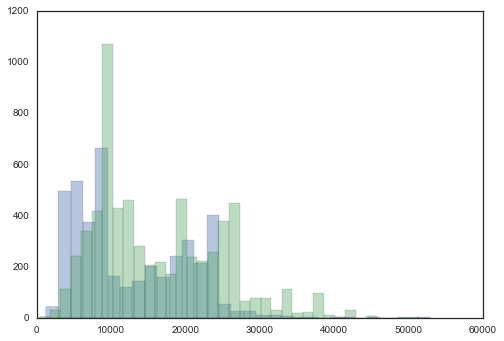

In [13]:
# Years with meadian student debt
from sets import Set
years = Set()
for row in debt:
    years.add(row[0])
    
print years

graphDistForYears(debt, 1998, 2012)

In [6]:
# Graph makes it look like there mgith be anomalies in the data such as negative debt, but 
# this is just a quirk of the regression and not an actual fact
print len([row[1] for row in debt if isinstance(row[1], float) and row[1] < 0])

0


In [7]:
# Net tuition revenue per student for a institution
tuitionRev = execute("""SELECT year, tuitfte, instnm, ugds
                  FROM Scorecard
                  WHERE tuitfte IS NOT NULL and main='Main campus' and ugds>1000""")

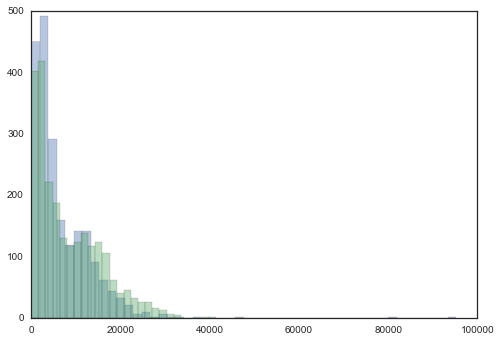

In [14]:
graphDistForYears(tuitionRev, 1998, 2012)

In [9]:
top10 = [[0,0,0] for i in range(0, 10)]
for inst in [row for row in tuitionRev if row[0]==1998]:
    i = 0
    done = False
    while i < len(top10) and not done:
        if (top10[i][1] < inst[1]):
            top10[i][0] = inst[2]
            top10[i][1] = inst[1]
            top10[i][2] = inst[3]
            done = True
        i += 1
            
for top in top10:
    print "{0} -- {1} -- {2}".format(top[0], top[1], top[2])

HARVARD UNIVERSITY -- 68001 -- 3567
MERCY COLLEGE-MAIN CAMPUS -- 33041 -- 1616
MIDDLEBURY COLLEGE -- 26671 -- 2273
WILLIAMS COLLEGE -- 21472 -- 2010
SWARTHMORE COLLEGE -- 20942 -- 1390
UNIVERSITY OF PENNSYLVANIA -- 20650 -- 11644
RHODE ISLAND SCHOOL OF DESIGN -- 19569 -- 1844
ALFRED UNIVERSITY -- 17080 -- 1228
COLGATE UNIVERSITY -- 15947 -- 2771
COLUMBIA UNIVERSITY IN THE CITY OF NEW YORK -- 15883 -- 6401


Odd outliers throughout needs to be explored and cleaned more

In [10]:
expenses = execute("""SELECT year, inexpfte
                  FROM Scorecard
                  WHERE inexpfte IS NOT NULL and main='Main campus' and ugds>1000""")

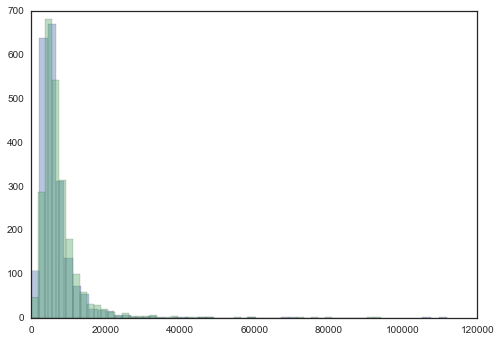

In [15]:
graphDistForYears(expenses, 1998, 2012)

In [27]:
purdueData = execute("""SELECT year, tuitfte, inexpfte, grad_debt_mdn
                        FROM Scorecard
                        WHERE instnm='PURDUE UNIVERSITY-MAIN CAMPUS'""")

In [28]:
purdueData[:10]

[(1996, None, None, None),
 (1997, None, None, 14434.0),
 (1998, 5404, 7163, 14375.0),
 (1999, 5775, 7566, 14038.5),
 (2000, 5974, 7391, 13625.0),
 (2001, 6610, 8079, 13818.0),
 (2002, 6188, 8471, 14330.0),
 (2003, 7181, 8499, 14500.0),
 (2004, 7978, 9224, 14500.0)]

In [35]:
def graphPurdueData(index):
    df = pd.DataFrame()
    df['Dollars'] = [adjustForInflation(row[index], row[0]) for row in purdueData]
    df['Year'] = [row[0] for row in purdueData]
    graph = sns.regplot('Year', 'Dollars',
                            data=df,
                            fit_reg=False)

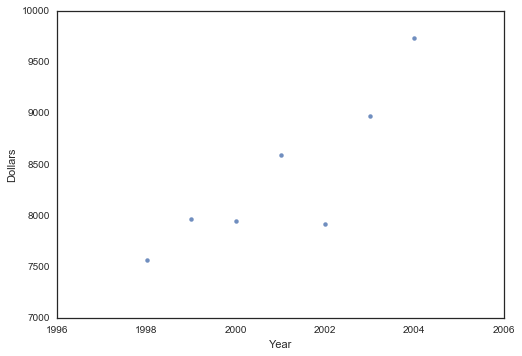

In [40]:
graphPurdueData(1)

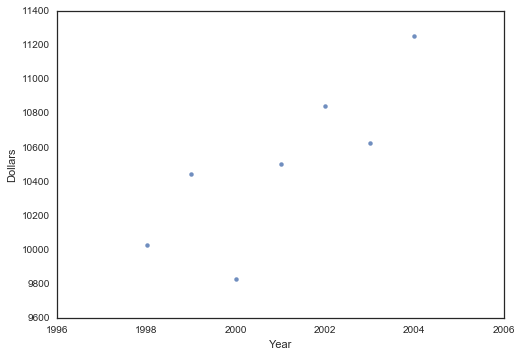

In [41]:
graphPurdueData(2)

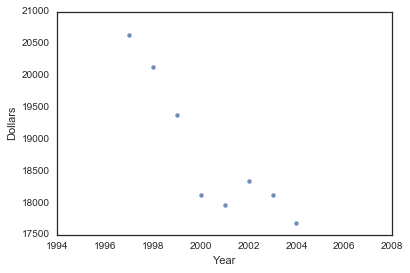

In [44]:
graphPurdueData(3)

Problems noted so far:
* lots of None data
* not all years recorded
* <b>Not inflation adjusted</b>
* small schools with outlier data included

To clean up:
* remove non-main campuses
* check and see if names change over time, possibly use inst number instead
* adjsut for inflation

### Notes so far
* Finding general patterns seems hard because of outliers
* Think find one or two interesting trends, then allow for individual comparisions/dashboard

Perhaps: 
1. Show general trends/generalized information --> Allow people to choose colleges to add and compare (Max 7)
2. Have "dashboard" to look at a specific college --> Allow people to compare colleges (Max 3)
3. Investigate on my own